In [1]:
import os, sys
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('text', usetex=True)

import time, datetime
import itertools
from joblib import Parallel, delayed
import pickle

In [2]:
data_name = 'alpha'

network_df = pd.read_csv('../rev2data/%s/%s_network.csv' %(data_name, data_name), header=None, names=['src', 'dest', 'rating', 'timestamp'], parse_dates=[3], infer_datetime_format=True)

user_list = ['u' + str(u) for u in network_df['src'].tolist()]

gt_df = pd.read_csv('../rev2data/%s/%s_gt.csv' %(data_name, data_name), header=None, names=['id', 'label'])
gt = dict([('u'+str(x[0]), x[1]) for x in zip(gt_df['id'], gt_df['label'])])

In [3]:
# alg_list = ['rev2', 'bad', 'bn', 'trust']
alg_list = ['bad', 'bn', 'rev2']

alg_res = {alg_name: pickle.load(open('../%sres/%s.pkl' %(alg_name, data_name), 'rb')) for alg_name in alg_list}

## Metrics grid
+ precision
+ recall

In [4]:
q = np.arange(2, 100, 5)/100
restart = True

def get_metrics(ytrue, yscore):
    '''get precision and recall at q percentile'''
    assert len(ytrue) == len(yscore)
    size = len(ytrue)
    prec_dict = {}
    recl_dict = {}
    for qq in q:
        cut = qq*size
        ypred = (np.arange(size) < cut) * 1
        prec = sklearn.metrics.precision_score(y_pred=ypred, y_true=ytrue)
        recl = sklearn.metrics.recall_score(y_pred=ypred, y_true=ytrue)
        prec_dict[qq] = prec
        recl_dict[qq] = recl
    return prec_dict, recl_dict

def compute_metrics(alg_name, k, n, ind):
    ulist = np.array(alg_res[alg_name][(k, n, ind)]['ulist'])
    yscore = np.array(alg_res[alg_name][(k, n, ind)]['yscore'])
    ytrue = np.array(alg_res[alg_name][(k, n, ind)]['ytrue'])
    # if alg_name in ['bn', 'trust']: ytrue = np.flip(ytrue)
    prec_dict, recl_dict = get_metrics(ytrue, yscore)
    return {'prec': prec_dict, 'recl': recl_dict}

pkl_path = '../res/%s.pkl' %data_name

if os.path.exists(pkl_path) and not restart:
    with open(pkl_path, 'rb') as f: metrics_dict = pickle.load(f)
    print('load from %s' %pkl_path)
else:
    print('compute from scratch')
    metrics_dict = {alg_name: Parallel(n_jobs=-1, verbose=5)(delayed(compute_metrics)(alg_name, k, n, ind) for k, n, ind in itertools.product(range(11), range(11), range(50))) for alg_name in alg_list}
    with open(pkl_path, 'wb') as f: pickle.dump(metrics_dict, f)
    print('save to %s' %pkl_path)

compute from scratch


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2130 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2994 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4560 tasks      | e

save to ../res/alpha.pkl


In [5]:
# target_list = ['comb']
met_list = ['prec', 'recl']

# plot_data_dict = {alg_name: {m: {} for m in met_list} for alg_name in alg_list}

plot_data_dict ={alg_name: dict(zip(itertools.product(range(11), range(11), range(50)), metrics_dict[alg_name])) for alg_name in alg_list}

In [6]:
color_map = {
    'rev2': 'blue',
    'bad': 'orange',
    'bn': 'green',
    'trust': 'red'
}

def plot_lines(ax, x, y_data, ylabel='', xlabel='', title='', e_data=None):
    lines = []
    for alg_name in alg_list:
        y = y_data[alg_name]
        lines += [ax.plot(x, y, marker='x', color=color_map[alg_name])[0]]
        if e_data != None:
            e = e_data[alg_name]
            ax.errorbar(x, y, e, linestyle='None', capsize=2, color=color_map[alg_name])
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_title(title, fontsize=13)
    return lines

## Plot precision for each k,n pair

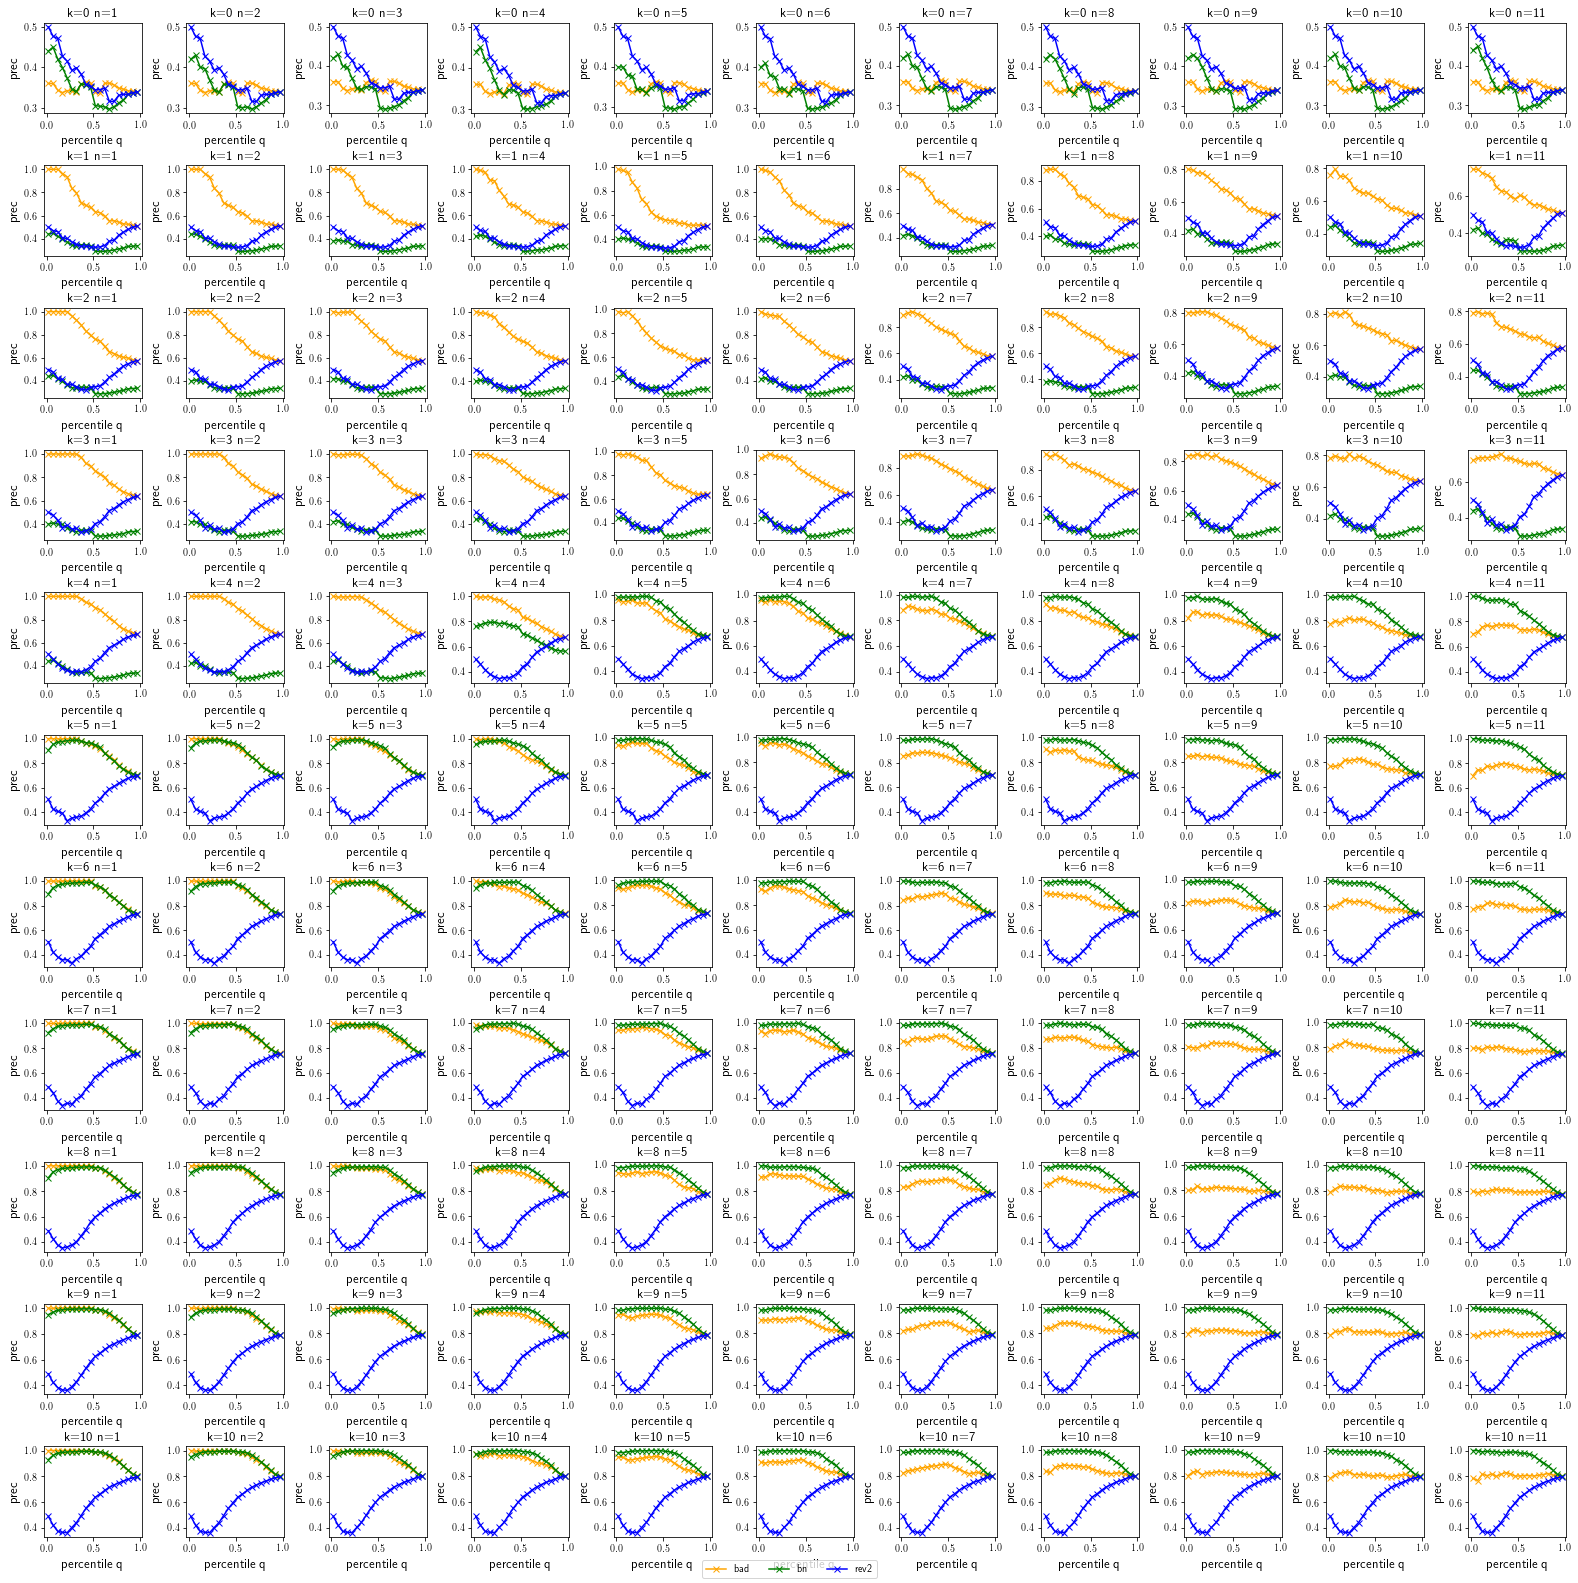

In [7]:
fig_prec, axes = plt.subplots(11, 11, figsize=(22, 22))
m = 'prec'

for k, n in itertools.product(range(11), range(11)):
    y_data = {}
    for alg_name in alg_list:
        y_data[alg_name] = [np.mean([plot_data_dict[alg_name][(k, n, ind)][m][qq] for ind in range(50)]) for qq in q]
    lines = plot_lines(axes[k, n], q, y_data, xlabel='percentile q', ylabel=m, title='k=%d n=%d' %(k, n+1), e_data=None)
    
fig_prec.tight_layout(pad=1, w_pad=0.3, h_pad=0.2)
fig_prec.legend(lines, alg_list, loc='lower center', ncol=len(alg_list), fontsize='medium')

## Plot recallfor each k,n pair

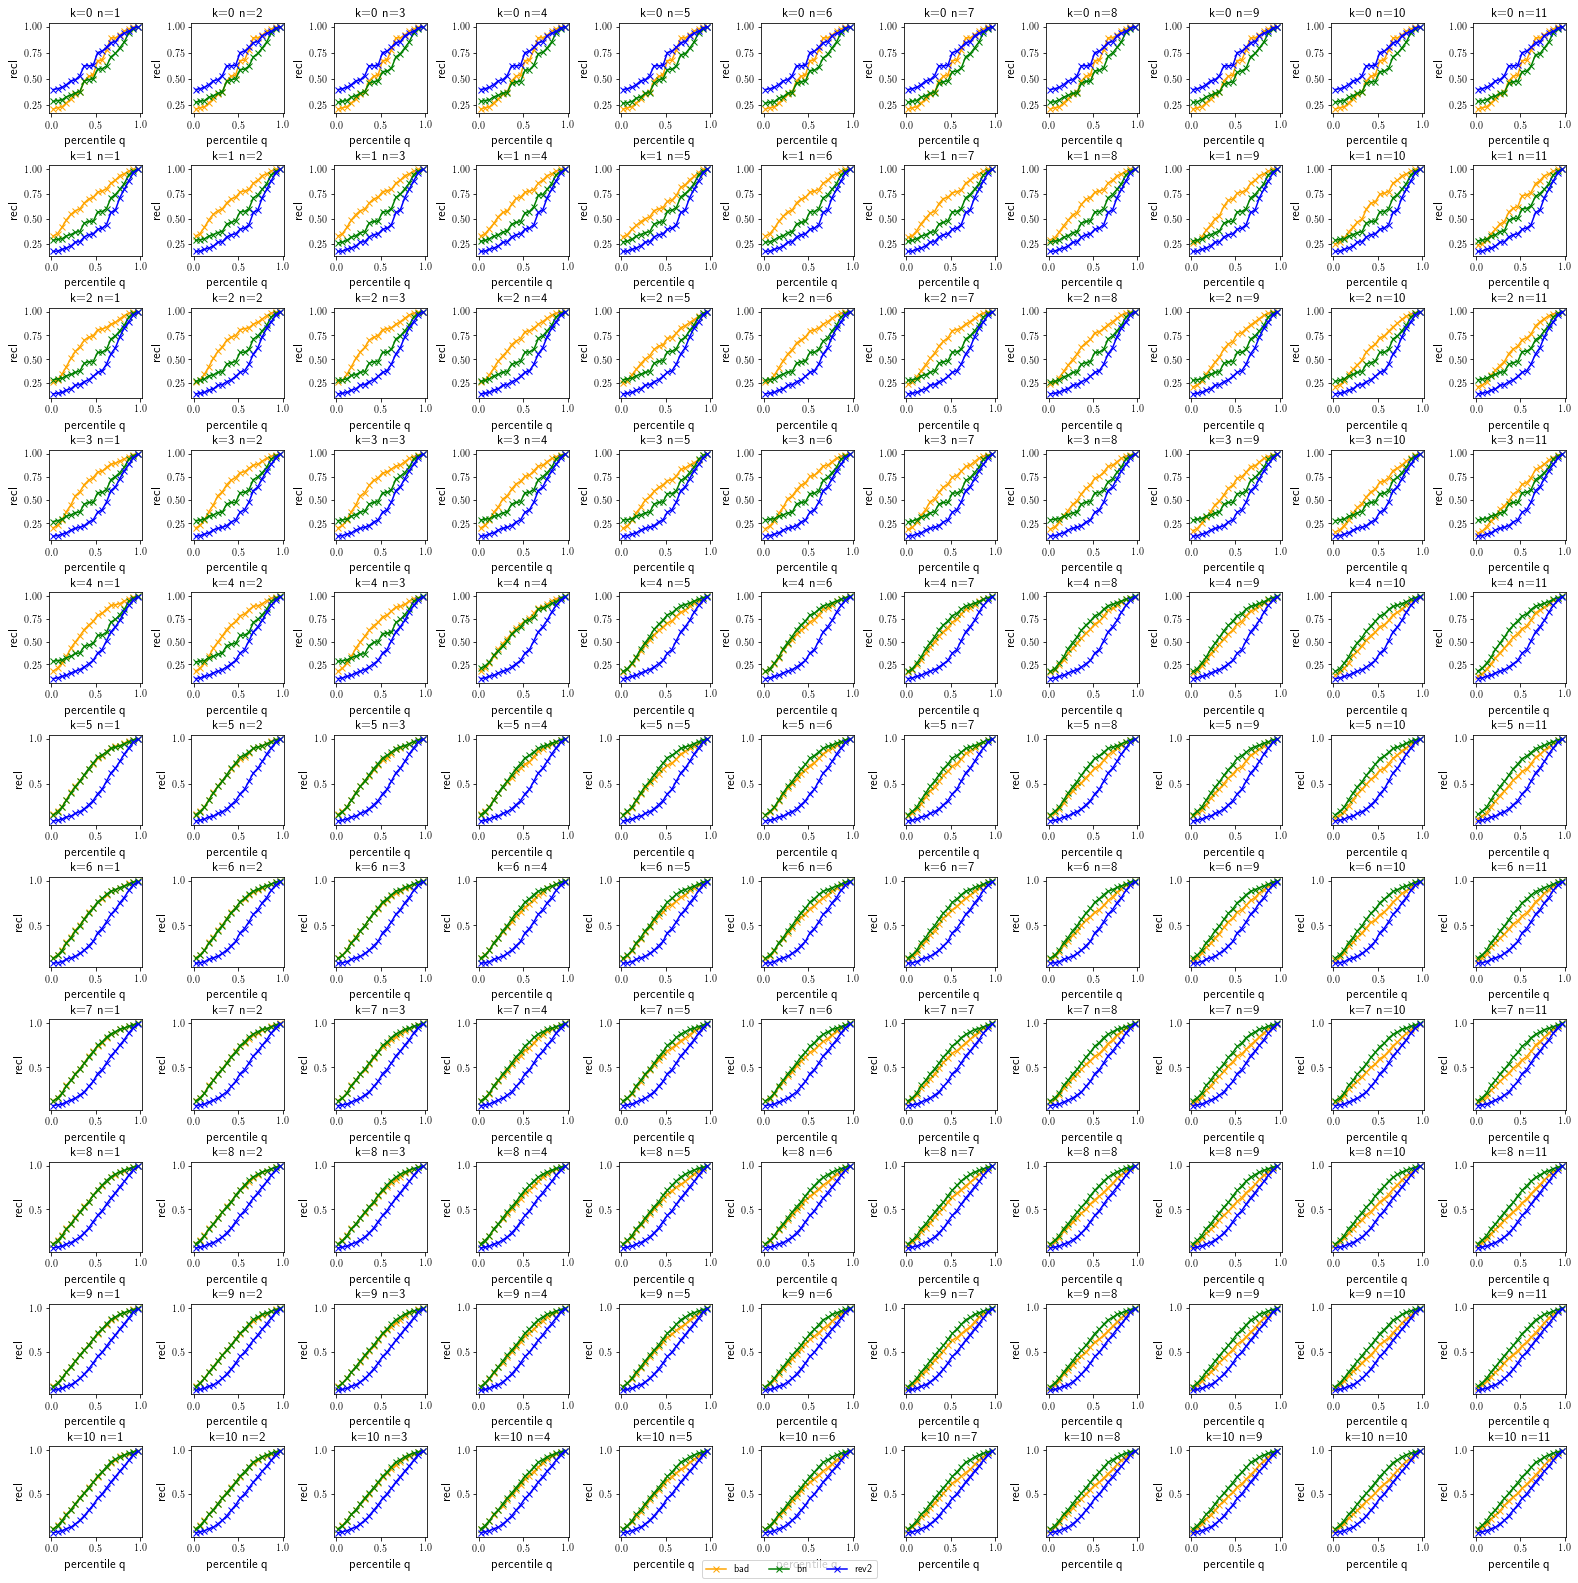

In [8]:
fig_recl, axes = plt.subplots(11, 11, figsize=(22, 22))
m = 'recl'

for k, n in itertools.product(range(11), range(11)):
    y_data = {}
    for alg_name in alg_list:
        y_data[alg_name] = [np.mean([plot_data_dict[alg_name][(k, n, ind)][m][qq] for ind in range(50)]) for qq in q]
    lines = plot_lines(axes[k, n], q, y_data, xlabel='percentile q', ylabel=m, title='k=%d n=%d' %(k, n+1), e_data=None)
    
fig_recl.tight_layout(pad=1, w_pad=0.3, h_pad=0.2)
fig_recl.legend(lines, alg_list, loc='lower center', ncol=len(alg_list), fontsize='medium')

In [9]:
fig_prec.savefig('../rev2fig/%s-prec.pdf' %data_name)
fig_recl.savefig('../rev2fig/%s-recl.pdf' %data_name)